In [44]:
import os
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from collections import defaultdict
import torch.nn as nn
import torch.nn.init as init
import matplotlib.pyplot as plt
import re

In [ ]:
class TemporalFloodDataset(Dataset):
    def __init__(self, directory, max_seq_len=8, augment=True, flood_noise_level=0.2, nonflood_noise_level=0.05):
        self.directory = directory
        self.data = []
        self.max_seq_len = max_seq_len
        self.augment = augment
        self.flood_noise_level = flood_noise_level
        self.nonflood_noise_level = nonflood_noise_level

        # Group files by event ID
        flood_events = defaultdict(list)
        nonflood_events = defaultdict(list)

        print(f"Looking for files in: {directory}")
        all_files = os.listdir(directory)
        print(f"Total files found: {len(all_files)}")
        
        # Scan the directory for files
        for fname in all_files:
            if fname.endswith('.pt'):
                if fname.startswith('NonFlood'):
                    # Extract non-flood event ID - get the number after "NonFlood_"
                    match = re.search(r'NonFlood_(\d+)', fname)
                    if match:
                        event_id = match.group(1)
                        nonflood_events[event_id].append(os.path.join(directory, fname))
                    else:
                        print(f"Warning: Couldn't parse event ID from {fname}")
                elif fname.startswith('PreFlood'):
                    # Extract flood event ID from filename - get the number after "PreFlood_t-7_to_t-0_"
                    match = re.search(r'PreFlood_t-7_to_t-0_(\d+)', fname)
                    if match:
                        event_id = match.group(1)
                        flood_events[event_id].append(os.path.join(directory, fname))
                    else:
                        print(f"Warning: Couldn't parse event ID from {fname}")

        print(f"Found {len(nonflood_events)} non-flood events with {sum(len(files) for files in nonflood_events.values())} files")
        print(f"Found {len(flood_events)} flood events")

        # Add non-flood data (group by event ID)
        for event_id, files in nonflood_events.items():
            files = sorted(files)
            self.data.append((files, 0))
            
        # Add flood data (multiple files per event)
        for event_id, files in flood_events.items():
            files = sorted(files)
            self.data.append((files, 1))
            print(f"✅ Dataset: {os.path.basename(files[0])} -> event_id: {event_id}")
            
        print(f"Dataset created with {len(self.data)} samples")
        print(f"Samples with label 0: {sum(1 for _, label in self.data if label == 0)}")
        print(f"Samples with label 1: {sum(1 for _, label in self.data if label == 1)}")

    def __len__(self):
        return len(self.data)
    
    def normalize(self, tensor):
        """Z-score normalization at tensor level to handle varying scales"""
        mean = tensor.mean()
        std = tensor.std() + 1e-5  # Avoid division by zero
        return (tensor - mean) / std
    
    def augment_data(self, tensor, is_flood=False):
        """More aggressive augmentation for flood samples"""
        if not self.augment:
            return tensor
            
        # Add random noise (stronger for flood samples)
        noise_level = self.flood_noise_level if is_flood else self.nonflood_noise_level
        noise = torch.randn_like(tensor) * noise_level
        tensor = tensor + noise
        
        # Random horizontal flip (50% chance)
        if torch.rand(1).item() > 0.5:
            tensor = torch.flip(tensor, dims=[-1])  # Flip along the width dimension
            
        # Random vertical flip (50% chance)
        if torch.rand(1).item() > 0.5:
            tensor = torch.flip(tensor, dims=[-2])  # Flip along the height dimension
            
        # For flood samples, add more augmentations
        if is_flood:
            # Random rotation (one of 90, 180, or 270 degrees)
            if torch.rand(1).item() > 0.5:
                k = torch.randint(1, 4, (1,)).item()  # Random number of 90-degree rotations
                tensor = torch.rot90(tensor, k, dims=[-2, -1])
                
            # Random intensity scaling
            if torch.rand(1).item() > 0.5:
                scale = 0.8 + 0.4 * torch.rand(1).item()  # Scale between 0.8 and 1.2
                tensor = tensor * scale
            
        return tensor

    def __getitem__(self, idx):
        item, label = self.data[idx]

        try:
            # Both flood and non-flood are now lists of files
            if not isinstance(item, list):
                print(f"Warning: Expected list but got {type(item)} at index {idx}")
                # Create single-element list as fallback
                item = [item]
                
            # Process all files in the event
            raw_imgs = [torch.load(p) for p in item]
            imgs = []
            
            for i in raw_imgs:
                if self.augment:
                    i = self.augment_data(i, is_flood=(label == 1))
                i = self.normalize(i)  # Apply normalization
                imgs.append(i)
                
            # Show stats of first image for debugging
            if idx == 0:
                print(f"First image stats: min={imgs[0].min().item():.4f}, max={imgs[0].max().item():.4f}, mean={imgs[0].mean().item():.4f}, std={imgs[0].std().item():.4f}")
                
            # Handle sequence length
            seq_len = len(imgs)
            C, H, W = imgs[0].shape
            
            if seq_len < self.max_seq_len:
                # Pad shorter sequences
                pad = [torch.zeros(C, H, W)] * (self.max_seq_len - seq_len)
                imgs.extend(pad)
            elif seq_len > self.max_seq_len:
                # Truncate longer sequences
                imgs = imgs[:self.max_seq_len]
                
            # Stack into tensor
            img = torch.stack(imgs)
            
        except Exception as e:
            print(f"Error loading sample {idx} ({item}): {e}")
            # Provide a fallback tensor
            img = torch.zeros(self.max_seq_len, 19, 128, 128)
            print(f"Using fallback tensor with shape {img.shape}")

        return img, torch.tensor(label, dtype=torch.float)

# Custom balanced batch sampler that ensures each batch has flood samples
class BalancedBatchSampler:
    def __init__(self, dataset, batch_size=8, flood_ratio=0.5):
        self.dataset = dataset
        self.batch_size = batch_size
        self.flood_ratio = flood_ratio
        
        # Find indices of flood and non-flood samples
        flood_indices = []
        nonflood_indices = []
        
        # Check the way to access labels based on dataset type
        if hasattr(dataset, 'data'):
            # Original dataset case
            flood_indices = [i for i, (_, label) in enumerate(dataset.data) if label == 1]
            nonflood_indices = [i for i, (_, label) in enumerate(dataset.data) if label == 0]
        else:
            # SubsetDataset case - access through getitem
            for i in range(len(dataset)):
                _, label = dataset[i]
                if label.item() == 1:
                    flood_indices.append(i)
                else:
                    nonflood_indices.append(i)
        
        self.flood_indices = flood_indices
        self.nonflood_indices = nonflood_indices
        
        # Calculate numbers per batch
        self.floods_per_batch = max(1, int(batch_size * flood_ratio))
        self.nonflood_per_batch = batch_size - self.floods_per_batch
        
        # Calculate number of batches
        self.num_batches = min(
            len(self.flood_indices) // self.floods_per_batch,
            len(self.nonflood_indices) // self.nonflood_per_batch
        )
        
        # Multiple the smaller class to make more batches
        repeat_factor = max(1, len(self.nonflood_indices) // (len(self.flood_indices) * 2))
        self.flood_indices = self.flood_indices * repeat_factor
        self.num_batches = min(
            len(self.flood_indices) // self.floods_per_batch,
            len(self.nonflood_indices) // self.nonflood_per_batch
        )
        
        print(f"Found {len(flood_indices)} flood samples and {len(nonflood_indices)} non-flood samples")
        print(f"Created balanced batch sampler with {self.floods_per_batch} flood and {self.nonflood_per_batch} non-flood samples per batch")
        print(f"Will create {self.num_batches} batches per epoch")
    
    def __iter__(self):
        # Shuffle indices
        np.random.shuffle(self.flood_indices)
        np.random.shuffle(self.nonflood_indices)
        
        for i in range(self.num_batches):
            batch_indices = []
            # Add flood samples
            batch_indices.extend(self.flood_indices[i*self.floods_per_batch:(i+1)*self.floods_per_batch])
            # Add non-flood samples
            batch_indices.extend(self.nonflood_indices[i*self.nonflood_per_batch:(i+1)*self.nonflood_per_batch])
            # Shuffle within batch
            np.random.shuffle(batch_indices)
            yield batch_indices
    
    def __len__(self):
        return self.num_batches

# Asymmetric BCE loss that penalizes false negatives more heavily
class AsymmetricBCELoss(nn.Module):
    def __init__(self, negative_weight=1.0, positive_weight=10.0):
        super(AsymmetricBCELoss, self).__init__()
        self.negative_weight = negative_weight
        self.positive_weight = positive_weight
        
    def forward(self, input, target):
        # Standard BCE loss calculation
        input = input.view(-1)
        target = target.view(-1)
        
        # Separate weights for positive and negative samples
        weights = torch.ones_like(target) * self.negative_weight
        weights[target > 0.5] = self.positive_weight
        
        loss = F.binary_cross_entropy_with_logits(input, target, weight=weights, reduction='mean')
        return loss

Using device: cpu
Looking for files in: preprocessed
Total files found: 150
Found 26 non-flood events with 104 files
Found 12 flood events
✅ Dataset: PreFlood_t-7_to_t-0_15_26.8948_93.3551-0000000000-0000000000-002_1.pt -> event_id: 15
✅ Dataset: PreFlood_t-7_to_t-0_17_20.9795_73.783-0000000000-0000000000_1.pt -> event_id: 17
✅ Dataset: PreFlood_t-7_to_t-0_18_19.5656_74.5501-0000000000-0000000000_1.pt -> event_id: 18
✅ Dataset: PreFlood_t-7_to_t-0_19_12.5238_75.6883-0000000000-0000000000_1.pt -> event_id: 19
✅ Dataset: PreFlood_t-7_to_t-0_23_26.0513_94.7655-0000000000-0000000000_1.pt -> event_id: 23
✅ Dataset: PreFlood_t-7_to_t-0_24_31.3414_76.6285-0000000000-0000000000_1.pt -> event_id: 24
✅ Dataset: PreFlood_t-7_to_t-0_25_17.9_83.3588-0000000000-0000000000_1.pt -> event_id: 25
✅ Dataset: PreFlood_t-7_to_t-0_26_21.5427_87.4662-0000000000-0000000000_1.pt -> event_id: 26
✅ Dataset: PreFlood_t-7_to_t-0_27_23.4991_91.5736-0000000000-0000000000_1.pt -> event_id: 27
✅ Dataset: PreFlood_t-7_

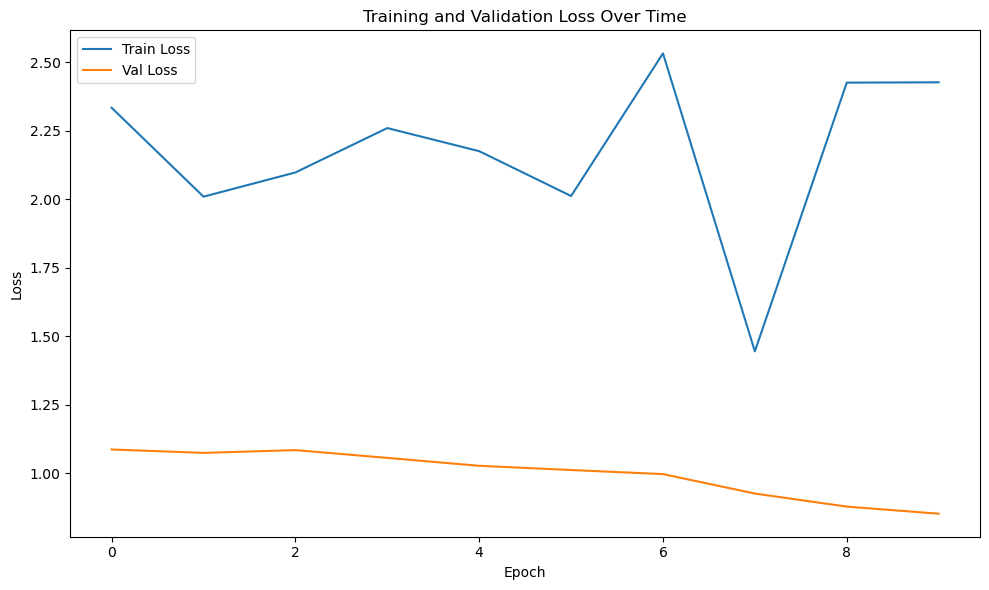

In [110]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import os
import re
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from collections import defaultdict, Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, precision_score, recall_score, f1_score

# Simplified CNN-LSTM model with focus on preventing overfitting
class SimplerCNNLSTM(nn.Module):
    def __init__(self, in_channels=19, hidden_dim=32, num_classes=1):
        super(SimplerCNNLSTM, self).__init__()
        
        # Simplified CNN with fewer filters and stronger regularization
        self.cnn = nn.Sequential(
            # First convolutional block
            nn.Conv2d(in_channels, 8, kernel_size=5, padding=2, stride=2),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.Dropout2d(0.4),
            
            # Second convolutional block
            nn.Conv2d(8, 16, kernel_size=3, padding=1, stride=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout2d(0.4),
            
            # Output pooling
            nn.AdaptiveAvgPool2d((4, 4))  # Output: [batch_size, 16, 4, 4]
        )
        
        # Feature size after CNN processing
        self.feature_size = 16 * 4 * 4  # Channels * height * width
        
        # Using LSTM instead of GRU
        self.lstm = nn.LSTM(
            input_size=self.feature_size,
            hidden_size=hidden_dim,
            num_layers=1,
            batch_first=True,
            dropout=0
        )
        
        # Add batch norm after LSTM
        self.bn = nn.BatchNorm1d(hidden_dim)
        
        # Classifier with strong regularization
        self.classifier = nn.Sequential(
            nn.Dropout(0.7),
            nn.Linear(hidden_dim, num_classes)
        )
    
    def forward(self, x):
        batch_size, seq_len, C, H, W = x.shape
        
        # Process each frame with CNN
        x = x.view(batch_size * seq_len, C, H, W)
        cnn_out = self.cnn(x)
        
        # Flatten spatial dimensions
        cnn_out = cnn_out.view(batch_size * seq_len, -1)
        
        # Reshape back to sequence format
        cnn_out = cnn_out.view(batch_size, seq_len, -1)
        
        # Process sequence with LSTM
        lstm_out, (h_n, _) = self.lstm(cnn_out)
        
        # Use final hidden state
        final_hidden = h_n.squeeze(0)
        
        # Apply batch normalization
        final_hidden = self.bn(final_hidden)
        
        # Apply classifier
        output = self.classifier(final_hidden)
        return output

# Main training script
def train_flood_model():
    # Setup
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Using device: {device}")
    in_channels = 19
    max_seq_len = 8

    # Load dataset
    dataset = TemporalFloodDataset('preprocessed', max_seq_len=max_seq_len, augment=True)

    # Examine class distribution
    all_labels = [dataset[i][1].item() for i in range(len(dataset))]
    label_counter = Counter(all_labels)
    print(f"Overall class distribution: {label_counter}")

    # Create train/val/test split
    indices = list(range(len(dataset)))
    train_indices, val_test_indices, train_labels, val_test_labels = train_test_split(
        indices, all_labels, test_size=0.3, stratify=all_labels, random_state=42
    )
    val_indices, test_indices = train_test_split(
        val_test_indices, test_size=0.5, stratify=val_test_labels, random_state=42
    )
    
    # Print class distribution for each split
    train_labels_subset = [dataset[i][1].item() for i in train_indices]
    val_labels_subset = [dataset[i][1].item() for i in val_indices]
    test_labels_subset = [dataset[i][1].item() for i in test_indices]
    
    print(f"Train set class distribution: {Counter(train_labels_subset)}")
    print(f"Validation set class distribution: {Counter(val_labels_subset)}")
    print(f"Test set class distribution: {Counter(test_labels_subset)}")

    # Create dataset subsets
    class SubsetDataset(Dataset):
        def __init__(self, dataset, indices):
            self.dataset = dataset
            self.indices = indices
        
        def __len__(self):
            return len(self.indices)
        
        def __getitem__(self, idx):
            return self.dataset[self.indices[idx]]

    train_dataset = SubsetDataset(dataset, train_indices)
    val_dataset = SubsetDataset(dataset, val_indices)
    test_dataset = SubsetDataset(dataset, test_indices)

    # Create data loaders
    batch_size = 4
    train_sampler = BalancedBatchSampler(train_dataset, batch_size=batch_size, flood_ratio=0.25)
    
    train_loader = DataLoader(
        train_dataset, 
        batch_sampler=train_sampler,
        num_workers=0,
        pin_memory=False
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=0,
        pin_memory=False
    )
    
    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=0,
        pin_memory=False
    )

    # Check data loader
    for x, y in train_loader:
        print(f"Batch shape: {x.shape}, Labels shape: {y.shape}")
        print(f"Label distribution in batch: {Counter(y.tolist())}")
        break

    # Initialize model with weight initialization to counter bias
    model = SimplerCNNLSTM(in_channels=in_channels).to(device)
    
    # Initialize weights with a negative bias for the final layer
    def init_weights(m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_normal_(m.weight)
            nn.init.constant_(m.bias, -1.0)  # Start with negative bias
    model.apply(init_weights)
    
    # Loss function and optimizer - favor non-flood predictions
    criterion = AsymmetricBCELoss(negative_weight=3.0, positive_weight=1.0)
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=5e-3)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=3, min_lr=1e-6)

    # Best model tracking
    best_val_loss = float('inf')
    best_model_state = None
    
    # Training parameters
    num_epochs = 10
    threshold = 0.3  # Start with a lower threshold to counter bias toward flood class
    
    # Track metrics
    train_losses, val_losses = [], []
    
    # Training loop
    for epoch in range(1, num_epochs + 1):
        # Training phase
        model.train()
        total_train_loss = 0
        
        for i, (x, y) in enumerate(train_loader):
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            
            # Apply mixup data augmentation 50% of the time
            if np.random.random() < 0.5:
                # Simple implementation of mixup
                lam = np.random.beta(0.2, 0.2)
                index = torch.randperm(x.size(0)).to(device)
                mixed_x = lam * x + (1 - lam) * x[index]
                out = model(mixed_x)
                loss = lam * criterion(out, y.unsqueeze(1)) + (1 - lam) * criterion(out, y[index].unsqueeze(1))
            else:
                out = model(x)
                loss = criterion(out, y.unsqueeze(1))
                
            loss.backward()
            # Tighter gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.1)
            optimizer.step()
            total_train_loss += loss.item()
        
        train_loss = total_train_loss / len(train_loader)
        train_losses.append(train_loss)
        
        # Validation phase
        model.eval()
        total_val_loss = 0
        val_preds, val_true = [], []
        
        with torch.no_grad():
            for x_val, y_val in val_loader:
                x_val, y_val = x_val.to(device), y_val.to(device)
                out = model(x_val)
                
                val_loss = criterion(out, y_val.unsqueeze(1))
                total_val_loss += val_loss.item()
                
                pred = (torch.sigmoid(out) > threshold).view(-1).long()
                val_preds.extend(pred.cpu().numpy().flatten().tolist())
                val_true.extend(y_val.long().cpu().numpy().flatten().tolist())
        
        val_loss = total_val_loss / len(val_loader)
        val_losses.append(val_loss)
        
        # Learning rate scheduler step
        scheduler.step(val_loss)
        
        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict().copy()
        
        # Calculate metrics
        val_precision, val_recall, val_f1, _ = precision_recall_fscore_support(
            val_true, val_preds, average='binary', zero_division=0
        )
        cm = confusion_matrix(val_true, val_preds)
        
        # Print epoch summary
        print(f"Val Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1: {val_f1:.4f}")
        print(f"Val Confusion Matrix:\n{cm}")
        print(f"[Epoch {epoch}] Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
    
    # Plot only losses vs epochs
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss Over Time')
    plt.tight_layout()
    plt.savefig('loss_history.png')
    
    # Save the best model
    if best_model_state is not None:
        torch.save(best_model_state, 'best_flood_model.pt')
    
    # Final evaluation with best model
    model.load_state_dict(best_model_state)
    model.eval()
    
    # Find best threshold
    all_outputs = []
    all_labels = []
    
    with torch.no_grad():
        for x_val, y_val in val_loader:
            x_val, y_val = x_val.to(device), y_val.to(device)
            out = model(x_val)
            probs = torch.sigmoid(out).cpu().numpy().flatten()
            all_outputs.extend(probs)
            all_labels.extend(y_val.cpu().numpy())
    
    # Find optimal threshold
    thresholds = np.arange(0.1, 0.9, 0.05)
    best_f1 = 0
    best_threshold = 0.5
    
    print("\nThreshold analysis:")
    for t in thresholds:
        preds = (np.array(all_outputs) > t).astype(int)
        precision = precision_score(all_labels, preds, zero_division=0)
        recall = recall_score(all_labels, preds, zero_division=0)
        f1 = f1_score(all_labels, preds, zero_division=0)
        
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = t
    
    print(f"\nBest threshold based on F1: {best_threshold:.2f}")
    
    # Test evaluation
    test_preds = []
    test_labels = []
    
    with torch.no_grad():
        for x_test, y_test in test_loader:
            x_test, y_test = x_test.to(device), y_test.to(device)
            out = model(x_test)
            probs = torch.sigmoid(out).cpu().numpy().flatten()
            preds = (probs > best_threshold).astype(int)
            test_preds.extend(preds)
            test_labels.extend(y_test.cpu().numpy())
    
    test_acc = (np.array(test_preds) == np.array(test_labels)).mean() * 100
    test_precision = precision_score(test_labels, test_preds, zero_division=0)
    test_recall = recall_score(test_labels, test_preds, zero_division=0)
    test_f1 = f1_score(test_labels, test_preds, zero_division=0)
    test_cm = confusion_matrix(test_labels, test_preds)
    
    print(f"\n🧪 Final Test Accuracy with threshold {best_threshold:.2f}: {test_acc:.2f}%")
    print(f"Test Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, F1: {test_f1:.4f}")
    print(f"Test Confusion Matrix:\n{test_cm}")
    
    return model, best_threshold

if __name__ == "__main__":
    train_flood_model()